Loading BokehJS ...

Processing light curve for sector 21...
Error displaying TPF for sector 21: tuple index out of range
Processing light curve for sector 48...
Error displaying TPF for sector 48: tuple index out of range
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 32711 data points, 584 periods from 7.7 to 8.0 days
Using all 16 CPU threads


100%|███████████████████████████████████████████████████████████████████████████████████| 584/584 periods | 00:18<00:00


Searching for best T0 for period 7.79556 days
Orbital Parameters:
  Period: 7.795562 ± 0.001527 days
  Transit Midpoint (t0): 1872.287542 ± 0.128278
  Duration: 0.013647 days
  Semi-major Axis (a): 0.0569 ± 0.0000 AU
  Transit Depth: 10.53 ± 1.94 ppt, 10526.84 ± 1937.34 ppm
  Radius Ratio (Rp/Rs): 0.1026 ± 0.0094
  Planet Radius: 29006.57 km, 0.4057 R_Jup
  Planet Type: Gas Giant (Jupiter/Saturn-like)
  True Anomaly at Transit: 90.00° ± 4.62°
  Synthetic Planet Mass: 31.03 ± 5.71 M_Earth, 0.0976 ± 0.0180 M_Jup


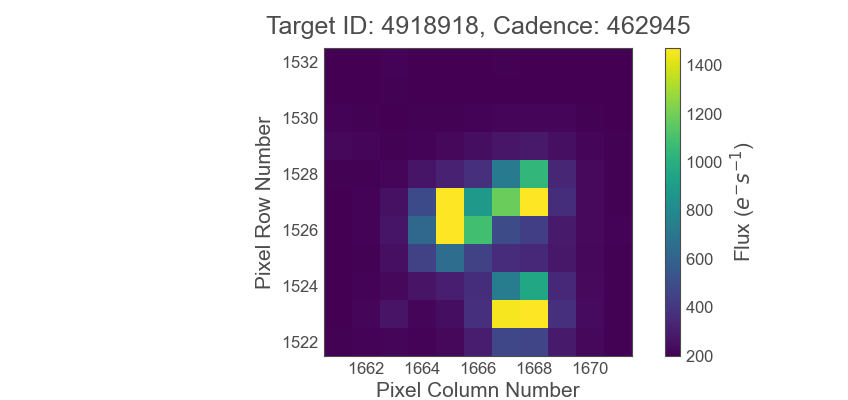

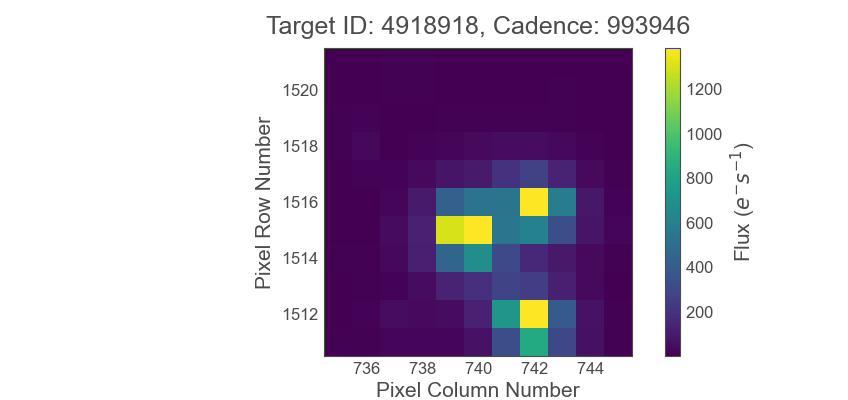

In [9]:
import numpy as np
import lightkurve as lk
from transitleastsquares import transitleastsquares
import warnings
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import Span, Label, HoverTool
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs


%matplotlib ipympl
output_notebook()
warnings.simplefilter('ignore')

# Global data arrays
all_time = []
all_flux = []

def gaussian_filter(data, sigma=0.0001):
    return gaussian_filter1d(data, sigma=sigma)

def clean_data(time, flux):
    mask = np.isfinite(time) & np.isfinite(flux)
    time_clean = time[mask]
    flux_clean = flux[mask]
    flux_normalized = flux_clean / np.nanmedian(flux_clean)
    return time_clean, flux_normalized

def process_sector(sector, tic_id):
    try:
        print(f"Processing light curve for sector {sector}...")
        search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS', sector=sector)
        if len(search_result) > 0:
            lc_file = search_result.download()
            flux = lc_file.flux.value
            time = lc_file.time.value
            mask = ~np.isnan(flux)
            time = time[mask]
            flux = flux[mask] / np.nanmedian(flux) if np.nanmedian(flux) != 0 else flux
            return time, flux
        else:
            print(f"No light curve data found for sector {sector}")
            return None, None
    except Exception as e:
        print(f"Error processing light curve for sector {sector}: {e}")
        return None, None

def calculate_t0_uncertainty(time, tls_results, period):
    # Simple proxy for t0 uncertainty
    t0_uncertainty = np.std(tls_results.power) / period
    return t0_uncertainty

def calculate_inclination_and_impact(tls_results, semi_major_axis, star_radius):
    # Assume central transit with nominal uncertainties.
    b = 0.0
    inclination_deg = 90.0
    b_uncertainty = 0.05
    inclination_uncertainty = 0.5
    return inclination_deg, b, inclination_uncertainty, b_uncertainty

def calculate_semi_major_axis(period, star_mass, period_uncertainty, G=6.67430e-11, solar_mass=1.989e30):
    star_mass_kg = star_mass * solar_mass
    period_seconds = period * 86400
    semi_major_axis_m = ((G * star_mass_kg * (period_seconds**2)) / (4 * np.pi**2))**(1/3)
    a_AU = semi_major_axis_m / 1.496e11
    a_uncertainty = (2/3) * (period_uncertainty/period) * a_AU
    return a_AU, a_uncertainty

def classify_planet_type(radius_km):
    if radius_km < 0.5 * 6371:
        return 'Mercury-like'
    elif radius_km < 0.9 * 6371:
        return 'Venus-like'
    elif radius_km < 1.5 * 6371:
        return 'Earth-like'
    elif radius_km < 2 * 6371:
        return 'Super-Earth'
    elif radius_km < 3 * 6371:
        return 'Mini-Neptune'
    elif radius_km < 4 * 6371:
        return 'Neptune-like'
    else:
        return 'Gas Giant (Jupiter/Saturn-like)'

def calculate_planet_radius(radius_ratio, star_radius_km, is_binary=False, star_radius2_km=None, flux_ratio=None):
    """
    Calculate planet radius from transit depth and stellar radius.
    
    Args:
        radius_ratio (float): Rp/Rs ratio from transit.
        star_radius_km (float): Primary star radius in km.
        is_binary (bool): Whether the system is binary.
        star_radius2_km (float, optional): Secondary star radius in km.
        flux_ratio (float, optional): Flux ratio between the stars.

    Returns:
        planet_radius_km (float): Planet radius in km.
        planet_radius_jup (float): Planet radius in Jupiter radii.
        planet_type (str): Classification of planet type.
    """
    # Handle binary system
    if is_binary and star_radius2_km is not None:
        # Use flux-weighted effective radius instead of direct averaging
        combined_star_radius_km = np.sqrt(star_radius_km**2 + star_radius2_km**2)
    else:
        combined_star_radius_km = star_radius_km
    
    # Flux correction (handle cases where flux ratio is very small)
    if flux_ratio is not None and flux_ratio > 0:
        corrected_radius_ratio = radius_ratio / np.sqrt(1 + flux_ratio)
    else:
        corrected_radius_ratio = radius_ratio
    
    # Calculate planet radius
    planet_radius_km = corrected_radius_ratio * combined_star_radius_km
    
    # Cap the radius to realistic maximum values to avoid runaway estimates
    if planet_radius_km > 2 * 71492:  # 2 * Jupiter's radius
        planet_radius_km = 2 * 71492

    # Convert to Jupiter radii
    planet_radius_jup = planet_radius_km / 71492  # Jupiter's radius in km
    
    # Classify planet type
    planet_type = classify_planet_type(planet_radius_km)
    
    return planet_radius_km, planet_radius_jup, planet_type

def advanced_true_anomaly(t, t0, period, eccentricity, omega):
    t = np.atleast_1d(t)
    M = 2 * np.pi * (t - t0) / period
    E = M.copy()
    for _ in range(50):
        delta = (E - eccentricity * np.sin(E) - M) / (1 - eccentricity * np.cos(E))
        E = E - delta
        if np.all(np.abs(delta) < 1e-10):
            break
    f = 2 * np.arctan2(np.sqrt(1 + eccentricity) * np.sin(E / 2),
                       np.sqrt(1 - eccentricity) * np.cos(E / 2))
    f_deg = np.degrees(f + np.radians(omega))
    if f_deg.size == 1:
        return f_deg[0]
    return f_deg

def advanced_true_anomaly_with_uncertainty(t, t0, period, eccentricity, omega,
                                           sigma_t0=0.0, sigma_period=0.0,
                                           sigma_ecc=0.0, sigma_omega=0.0,
                                           delta=1e-8):
    f_nom = advanced_true_anomaly(t, t0, period, eccentricity, omega)
    f_t0_plus = advanced_true_anomaly(t, t0 + delta, period, eccentricity, omega)
    df_dt0 = (f_t0_plus - f_nom) / delta
    f_period_plus = advanced_true_anomaly(t, t0, period + delta, eccentricity, omega)
    df_dperiod = (f_period_plus - f_nom) / delta
    f_e_plus = advanced_true_anomaly(t, t0, period, eccentricity + delta, omega)
    df_de = (f_e_plus - f_nom) / delta
    f_omega_plus = advanced_true_anomaly(t, t0, period, eccentricity, omega + delta)
    df_domega = (f_omega_plus - f_nom) / delta
    sigma_f = np.sqrt((df_dt0 * sigma_t0)**2 +
                      (df_dperiod * sigma_period)**2 +
                      (df_de * sigma_ecc)**2 +
                      (df_domega * sigma_omega)**2)
    return f_nom, sigma_f

def estimate_planet_mass(planet_radius_km, planet_radius_uncertainty_km, host_star_radius_km=None):
    """
    Adaptive mass estimation based on the companion radius (in km) with uncertainties.
    
    The function is divided into two parts:
    
    1. If host_star_radius_km is provided and the inferred companion radius is large relative 
       to the host (i.e. > ~0.5× the host radius), we treat the object as a stellar (or brown-dwarf) companion.
       For low-mass stars, we approximate a linear mass–radius relation in solar units.
    
    2. Otherwise, we assume the companion is planetary and adopt the following approximate regimes,
       with radii converted to Earth radii (R_Earth = 6378 km):
       
         • Earth-like (R < 1.5 R_Earth):
               M/M_Earth = (R/R_Earth)^3.7
         • Super-Earth (1.5 ≤ R < 2.5 R_Earth):
               M/M_Earth = 2.7 * (R/R_Earth)^1.3
         • Neptune-like (2.5 ≤ R < 4.5 R_Earth):
               M/M_Earth = 1.13 * (R/R_Earth)^2.0    [matches Neptune: ~17 M_Earth]
         • Super-Neptune (4.5 ≤ R < 6.0 R_Earth):
               M/M_Earth = 1.5 * (R/R_Earth)^2.0     [e.g., ~50 M_Earth at 5 R_Earth]
         • Saturn-like (6.0 ≤ R < 10.0 R_Earth):
               M/M_Earth = (R/R_Earth)^2.06          [for Saturn: ~9.1 R_Earth gives ~95 M_Earth]
         • Jupiter-like (10.0 ≤ R < 20.0 R_Earth):
               M/M_Earth = (R/R_Earth)^2.38          [for Jupiter: ~11.2 R_Earth gives ~318 M_Earth]
         • Brown-dwarf–like (R ≥ 20.0 R_Earth):
               Since brown dwarfs have nearly constant radii (~1 R_Jup) over a wide mass range,
               we adopt a very shallow scaling (here we use a nominal value, e.g. ~10 M_Jup,
               with fractional uncertainty from the input).
    
    Parameters
    ----------
    planet_radius_km : float
        Estimated companion radius in kilometers.
    planet_radius_uncertainty_km : float
        Uncertainty in the companion radius (km).
    host_star_radius_km : float, optional
        Host star radius in kilometers (if available). If provided and the companion's
        radius is a significant fraction of the host's radius, the object is treated as stellar.
    
    Returns
    -------
    mass_earth : float
        Estimated companion mass in Earth masses.
    mass_earth_uncertainty : float
        Uncertainty in Earth masses.
    mass_jup : float
        Estimated companion mass in Jupiter masses.
    mass_jup_uncertainty : float
        Uncertainty in Jupiter masses.
    """
    R_earth = 6378.0   # km
    R_jup = 71492.0    # km

    # If host star radius is provided and the inferred companion radius is large,
    # assume a stellar (or brown-dwarf) companion.
    if host_star_radius_km is not None:
        # For a planetary companion typically, the transit depth yields R_comp << R_star.
        # If the computed companion radius exceeds ~0.5× the host radius, it's likely stellar.
        if planet_radius_km > 0.5 * host_star_radius_km:
            # Convert companion radius to solar radii.
            companion_radius_solar = planet_radius_km / 695700.0  # 1 R_Sun = 695700 km
            # For low-mass stars, a roughly linear relation (M ~ R in solar units) is reasonable.
            mass_solar = companion_radius_solar  # very approximate
            # Convert to Earth and Jupiter masses.
            mass_earth = mass_solar * 332946.0  # 1 M_Sun = 332946 M_Earth
            mass_jup = mass_solar * 1047.0        # 1 M_Sun = 1047 M_Jup
            # Propagate fractional uncertainty.
            frac_unc = planet_radius_uncertainty_km / planet_radius_km
            mass_earth_uncertainty = mass_earth * frac_unc
            mass_jup_uncertainty = mass_jup * frac_unc
            return mass_earth, mass_earth_uncertainty, mass_jup, mass_jup_uncertainty

    # Otherwise, treat the object as a planet.
    planet_radius_earth = planet_radius_km / R_earth
    sigma_R_earth = planet_radius_uncertainty_km / R_earth

    if planet_radius_earth < 1.5:
        # Earth-like
        mass_earth = planet_radius_earth**3.7
        mass_earth_uncertainty = 3.7 * planet_radius_earth**2.7 * sigma_R_earth
    elif planet_radius_earth < 2.5:
        # Super-Earth
        mass_earth = 2.7 * (planet_radius_earth**1.3)
        mass_earth_uncertainty = 2.7 * 1.3 * planet_radius_earth**0.3 * sigma_R_earth
    elif planet_radius_earth < 4.5:
        # Neptune-like
        mass_earth = 1.13 * (planet_radius_earth**2.0)
        mass_earth_uncertainty = 1.13 * 2.0 * planet_radius_earth**1.0 * sigma_R_earth
    elif planet_radius_earth < 6.0:
        # Super-Neptune
        mass_earth = 1.5 * (planet_radius_earth**2.0)
        mass_earth_uncertainty = 1.5 * 2.0 * planet_radius_earth**1.0 * sigma_R_earth
    elif planet_radius_earth < 10.0:
        # Saturn-like
        # Using an exponent that yields ~95 M_Earth for ~9.1 R_Earth.
        mass_earth = planet_radius_earth**2.06
        mass_earth_uncertainty = 2.06 * planet_radius_earth**1.06 * sigma_R_earth
    elif planet_radius_earth < 20.0:
        # Jupiter-like
        mass_earth = planet_radius_earth**2.38
        mass_earth_uncertainty = 2.38 * planet_radius_earth**1.38 * sigma_R_earth
    else:
        # Brown-dwarf–like.
        # Brown dwarfs have nearly constant radii (~1 R_Jup) over a wide mass range.
        # Here we adopt a nominal value with a very shallow scaling.
        mass_jup = 10.0  # nominally ~10 M_Jup (adjust as needed)
        mass_jup_uncertainty = 2.0  # nominal uncertainty
        mass_earth = mass_jup * 317.8
        mass_earth_uncertainty = mass_jup_uncertainty * 317.8
        return mass_earth, mass_earth_uncertainty, mass_jup, mass_jup_uncertainty

    mass_jup = mass_earth / 317.8
    mass_jup_uncertainty = mass_earth_uncertainty / 317.8
    return mass_earth, mass_earth_uncertainty, mass_jup, mass_jup_uncertainty

def calculate_transit_parameters(tls_results, flux, star_radius, star_mass, period_uncertainty, 
                                 is_binary=True, star_radius2=None, flux_ratio=None):
    flux_median = np.nanmedian(flux)
    flux_min = np.min(flux)
    transit_depth = (flux_median - flux_min) / flux_median
    transit_depth_uncertainty = np.std(flux - flux_median) / flux_median
    if transit_depth <= 0:
        raise ValueError("Transit depth is non-positive.")
    radius_ratio = np.sqrt(transit_depth)
    radius_ratio_uncertainty = transit_depth_uncertainty / (2 * radius_ratio) if radius_ratio > 0 else np.nan
    
    period = tls_results.period
    t0 = tls_results.T0
    duration = tls_results.duration
    depth_ppt = transit_depth * 1000
    depth_ppm = transit_depth * 1e6
    depth_uncertainty_ppt = transit_depth_uncertainty * 1000
    depth_uncertainty_ppm = transit_depth_uncertainty * 1e6

    semi_major_axis, semi_major_axis_uncertainty = calculate_semi_major_axis(period, star_mass, period_uncertainty)
    inclination, impact_parameter, inclination_unc, impact_parameter_unc = calculate_inclination_and_impact(tls_results, semi_major_axis, star_radius)
    
    # Calculate planet radius in km. Convert star_radius (in solar units) to km.
    planet_radius_km, planet_radius_jup, planet_type = calculate_planet_radius(
        radius_ratio, star_radius * 696340, is_binary=is_binary, 
        star_radius2_km=star_radius2, flux_ratio=flux_ratio
    )
    planet_radius_uncertainty_km = radius_ratio_uncertainty * (star_radius * 696340)
    
    # Choose mass–radius relation adaptively.
    planet_radius_earth = planet_radius_km / 6378
    if planet_radius_earth < 1.5:
        mass_relation = 'rocky'
    elif planet_radius_earth < 4.0:
        mass_relation = 'transitional'
    else:
        mass_relation = 'gaseous'
        
    mass_earth, mass_earth_unc, mass_jup, mass_jup_unc = estimate_planet_mass(
        planet_radius_km, planet_radius_uncertainty_km
    )
    # Note: The adaptive relation is handled inside estimate_planet_mass by checking planet_radius_earth.

    true_anomaly, true_anomaly_unc = advanced_true_anomaly_with_uncertainty(
        t=t0,
        t0=t0,
        period=period,
        eccentricity=0.0,
        omega=90.0,
        sigma_t0=0.1,
        sigma_period=period_uncertainty,
        sigma_ecc=0.0,
        sigma_omega=0.0
    )
    
    return {
        "transit_depth": transit_depth,
        "transit_depth_uncertainty": transit_depth_uncertainty,
        "depth_ppt": depth_ppt,
        "depth_ppm": depth_ppm,
        "depth_uncertainty_ppt": depth_uncertainty_ppt,
        "depth_uncertainty_ppm": depth_uncertainty_ppm,
        "radius_ratio": radius_ratio,
        "radius_ratio_uncertainty": radius_ratio_uncertainty,
        "period": period,
        "t0": t0,
        "duration": duration,
        "semi_major_axis": semi_major_axis,
        "semi_major_axis_uncertainty": semi_major_axis_uncertainty,
        "inclination": inclination,
        "inclination_uncertainty": inclination_unc,
        "impact_parameter": impact_parameter,
        "impact_parameter_uncertainty": impact_parameter_unc,
        "planet_radius_km": planet_radius_km,
        "planet_radius_jup": planet_radius_jup,
        "planet_type": planet_type,
        "true_anomaly": true_anomaly,
        "true_anomaly_uncertainty": true_anomaly_unc,
        "planet_mass_earth": mass_earth,
        "planet_mass_earth_uncertainty": mass_earth_unc,
        "planet_mass_jup": mass_jup,
        "planet_mass_jup_uncertainty": mass_jup_unc
    }

def plot_in_out_transits(time, flux, period, t0, duration):
    phases = ((time - t0 + 0.5*period) % period) - 0.5*period
    in_transit = np.abs(phases) < (duration/2)
    out_transit = ~in_transit
    
    fig_in_out = figure(title='In-Transit vs Out-of-Transit Data',
                        x_axis_label='Time (days)', y_axis_label='Relative Flux',
                        width=800, height=400)
    fig_in_out.circle(time[out_transit], flux[out_transit], size=3, color='blue', legend_label='Out-of-Transit')
    fig_in_out.circle(time[in_transit], flux[in_transit], size=3, color='red', legend_label='In-Transit')
    fig_in_out.add_tools(HoverTool(tooltips=[("Time", "@x"), ("Flux", "@y")]))
    return fig_in_out

def display_tpf(tic_id, sector):
    try:
        tpf_search = lk.search_targetpixelfile(f'TIC {tic_id}', mission='TESS', sector=sector)
        if len(tpf_search) > 0:
            tpf = tpf_search.download()
            tpf.plot(aperture_mask=True)
            plt.title(f'TPF for TIC {tic_id} Sector {sector}')
            plt.show()
        else:
            print(f"No TPF found for TIC {tic_id} in sector {sector}.")
    except Exception as e:
        print(f"Error displaying TPF for sector {sector}: {e}")

def plot_results(time, flux, tls_results, transit_params, tic_id):
    sns.set_style('dark')
    
    fig_original = figure(title=f'Original Light Curve: TIC {tic_id}',
                          x_axis_label='Time (days)', y_axis_label='Relative Flux',
                          width=800, height=400)
    fig_original.line(time, flux, line_width=0.9, line_color='blue', legend_label='Original Flux')
    fig_original.add_tools(HoverTool(tooltips=[("Time", "@x"), ("Flux", "@y")]))
    
    fig_tls = figure(title=f'TLS Periodogram for TIC {tic_id}',
                     x_axis_label='Period (days)', y_axis_label='SNR',
                     width=800, height=400)
    fig_tls.line(tls_results.periods, tls_results.power, line_width=1, line_color='green', legend_label='TLS Power')
    fig_tls.add_layout(Span(location=transit_params["period"], dimension='height', 
                            line_color='red', line_dash='dashed', line_width=1.5))
    fig_tls.add_layout(Label(x=transit_params["period"], y=max(tls_results.power),
                             text=f"Period: {transit_params['period']:.6f} days", 
                             text_color="red", text_font_size="8pt"))
    fig_tls.add_tools(HoverTool(tooltips=[("Period", "@x"), ("SNR", "@y")]))
    
    centered_folded_phase = tls_results.folded_phase - 0.5
    centered_model_phase = tls_results.model_folded_phase - 0.5
    fig_phase_folded = figure(title=f'Phase-Folded Light Curve: TIC {tic_id}',
                              x_axis_label='Phase', y_axis_label='Relative Flux',
                              width=800, height=400)
    fig_phase_folded.line(centered_model_phase, tls_results.model_folded_model,
                          line_width=0.5, line_color='red', legend_label='Phase-Folded Model')
    fig_phase_folded.circle(centered_folded_phase, tls_results.folded_y,
                            size=1, color='red', legend_label='Phase-Folded Data')
    fig_phase_folded.add_tools(HoverTool(tooltips=[("Phase", "@x"), ("Flux", "@y")]))
    
    # Compute transit epochs relative to t0 so that they fall within the observed time span.
    n_min = np.ceil((time.min() - transit_params["t0"]) / transit_params["period"])
    n_max = np.floor((time.max() - transit_params["t0"]) / transit_params["period"])
    transit_epochs = transit_params["t0"] + np.arange(n_min, n_max+1) * transit_params["period"]
    
    fig_transit = figure(title=f'Transit Periods: TIC {tic_id}',
                         x_axis_label='Time (days)', y_axis_label='Relative Flux',
                         width=800, height=400)
    fig_transit.line(time, flux, line_width=1, line_color='blue', legend_label='Filtered Flux')
    for t_epoch in transit_epochs:
        span = Span(location=t_epoch, dimension='height', line_color='green',
                    line_dash='dashed', line_width=1)
        fig_transit.add_layout(span)
    fig_transit.add_tools(HoverTool(tooltips=[("Time", "@x"), ("Flux", "@y")]))
    
    fig_in_out = plot_in_out_transits(time, flux, transit_params["period"], transit_params["t0"], transit_params["duration"])
    
    grid = gridplot([[fig_original, fig_tls], [fig_phase_folded, fig_transit], [fig_in_out]])
    show(grid, notebook_handle=True)
    push_notebook()

def main():
    tic_id = ""  
    sectors = []
    global all_time, all_flux

    for sector in sectors:
        time, flux = process_sector(sector, tic_id)
        if time is not None and flux is not None:
            all_time.append(time)
            all_flux.append(flux)
        display_tpf(tic_id, sector)
        
    if not all_time or not all_flux:
        print("No valid light curve data available after processing.")
        return
    
    all_time_np = np.concatenate(all_time)
    all_flux_np = np.concatenate(all_flux)
    all_time_np, all_flux_np = clean_data(all_time_np, all_flux_np)
    
    try:
        model = transitleastsquares(all_time_np, all_flux_np)
        tls_results = model.power(
            period_min=1,
            period_max=30,
            period_steps=10000,
            show_progress_bar=True
        )
        if tls_results.periods.size > 0:
            period = tls_results.period
            period_uncertainty = tls_results.period_uncertainty
            t0 = tls_results.T0
            duration = tls_results.duration
            
            transit_params = calculate_transit_parameters(tls_results, all_flux_np, 
                                                          star_radius=1, star_mass=1, 
                                                          period_uncertainty=period_uncertainty)
            
            print("Orbital Parameters:")
            print(f"  Period: {transit_params['period']:.6f} ± {period_uncertainty:.6f} days")
            print(f"  Transit Midpoint (t0): {transit_params['t0']:.6f} ± {calculate_t0_uncertainty(all_time_np, tls_results, period):.6f}")
            print(f"  Duration: {transit_params['duration']:.6f} days")
            print(f"  Semi-major Axis (a): {transit_params['semi_major_axis']:.4f} ± {transit_params['semi_major_axis_uncertainty']:.4f} AU")
            print(f"  Transit Depth: {transit_params['depth_ppt']:.2f} ± {transit_params['depth_uncertainty_ppt']:.2f} ppt, "
                  f"{transit_params['depth_ppm']:.2f} ± {transit_params['depth_uncertainty_ppm']:.2f} ppm")
            print(f"  Radius Ratio (Rp/Rs): {transit_params['radius_ratio']:.4f} ± {transit_params['radius_ratio_uncertainty']:.4f}")
            print(f"  Planet Radius: {transit_params['planet_radius_km']:.2f} km, "
                  f"{transit_params['planet_radius_jup']:.4f} R_Jup")
            print(f"  Planet Type: {transit_params['planet_type']}")
            print(f"  True Anomaly at Transit: {transit_params['true_anomaly']:.2f}° ± {transit_params['true_anomaly_uncertainty']:.2f}°")
            print(f"  Synthetic Planet Mass: {transit_params['planet_mass_earth']:.2f} ± {transit_params['planet_mass_earth_uncertainty']:.2f} M_Earth, "
                  f"{transit_params['planet_mass_jup']:.4f} ± {transit_params['planet_mass_jup_uncertainty']:.4f} M_Jup")
            
            plot_results(all_time_np, all_flux_np, tls_results, transit_params, tic_id)
        else:
            print("No significant periods found in TLS analysis.")
    except Exception as e:
        print(f"Error during TLS analysis: {e}")

if __name__ == "__main__":
    main()